In [74]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns

In [4]:
adata = sc.read('../../data/predicted_root.h5ad')
adata

AnnData object with n_obs × n_vars = 7527 × 20501
    obs: 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.8', 'seurat_clusters', 'nCount_ADT', 'ref_celltype', 'louvain', 'celltype_level0', 'cluster_detail'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [3]:
adata.obs.head()

,nCount_RNA,nFeature_RNA,RNA_snn_res.0.8,seurat_clusters,nCount_ADT,ref_celltype,louvain,celltype_level0,cluster_detail
TACAGTGTCTCGGACG,31201.0,5021,13,13,513.0,Eryth,15,Erythrocytes,15
GTTTCTACATCATCCC,23145.0,5082,13,13,710.0,Eryth,12,CD34+,12
GTACGTATCCCATTTA,26069.0,4149,13,13,754.0,Eryth,15,Erythrocytes,15
ATGTGTGGTCGCCATG,25812.0,4160,13,13,705.0,Eryth,15,Erythrocytes,15
AACGTTGTCAGTTAGC,19307.0,3452,13,13,541.0,Eryth,15,Erythrocytes,15


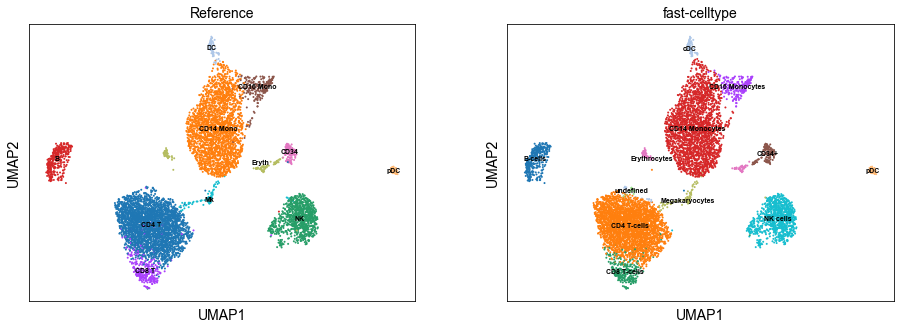

In [5]:
sc.set_figure_params(figsize=(7,5))
sc.pl.umap(adata,color=['ref_celltype','celltype_level0'],legend_loc='on data',legend_fontsize='x-small',
    title=['Reference','fast-celltype'])


In [6]:
for ct in adata.obs.ref_celltype.unique():
    print(ct)

Eryth
CD14 Mono
Mk
CD34
DC
CD4 T
CD8 T
CD16 Mono
B
NK
pDC


In [7]:
for ct in adata.obs.celltype_level0.unique():
    print(ct)

Erythrocytes
CD34+
CD14 Monocytes
Megakaryocytes
cDC
CD4 T-cells
CD8 T-cells
CD16 Monocytes
B-cells
NK cells
pDC
undefined


In [22]:
# ct_check_df = pd.read_csv('./celltype_checkcheet.txt',sep='\t',header=0)
# ct_check_df.head()
ct_check_dict = {}
with open('./celltype_checkcheet.txt','r',encoding='utf-8') as indata:
    title = indata.readline().rstrip('\n').split('\t')
    for line in indata:
        line_list = line.rstrip('\n').split('\t')
        ref_idx = title.index('Reference')
        predicted_idx = title.index('Prediction')
        ref_ct = line_list[ref_idx]
        predicted_ct = line_list[predicted_idx] 
        ct_check_dict[ref_ct] = [ct.strip() for ct in predicted_ct.split(',')]
ct_check_dict

{'Eryth': ['Erythrocytes'],
 'CD14 Mono': ['CD14 Monocytes'],
 'Mk': ['Megakaryocytes'],
 'CD34': ['CD34+'],
 'DC': ['cDC', 'pDC'],
 'CD4 T': ['CD4 T-cells'],
 'CD8 T': ['CD8 T-cells'],
 'CD16 Mono': ['CD16 Monocytes'],
 'B': ['B-cells'],
 'NK': ['NK cells'],
 'pDC': ['pDC']}

In [38]:
adata.obs.shape

(7527, 9)

In [65]:
def groupby_precision(df,predicted_col,check_dict):
    'df.name is the name of groupby'
    # print(df)
    boolean_series = df.apply(lambda row: row[predicted_col] in check_dict[df.name],axis=1)
    # boolean_series = df.apply(lambda row: print(row[predicted_col]),axis=1)
    total_len = len(boolean_series)
    right_len = len([1 for e in  boolean_series if e == True])
    return round(right_len/total_len,2)

In [75]:
ref_col = 'ref_celltype'
predicted_col = 'celltype_level0'
precision_df = adata.obs[[ref_col,predicted_col]].groupby(ref_col).apply(groupby_precision,predicted_col=predicted_col,check_dict=ct_check_dict).reset_index()
precision_df.columns=[ref_col,'precision']
precision_df

,ref_celltype,precision
0,CD4 T,0.98
1,CD14 Mono,1.00
2,NK,1.00
3,B,1.00
4,CD8 T,0.81
5,CD16 Mono,0.90
6,CD34,1.00
7,Eryth,0.76
8,Mk,0.91
9,DC,0.91


In [96]:
total_boolean_series = adata.obs[[ref_col,predicted_col]].apply(lambda row:row[predicted_col] in ct_check_dict[row[ref_col]],axis=1)
total_precision = len(total_boolean_series[total_boolean_series == True]) / len(total_boolean_series)
# total_precision = round(total_right_percent,2)
total_precision

0.9740932642487047

In [83]:
precision_df.sort_values(by='precision',ascending=False).ref_celltype

1     CD14 Mono
2            NK
3             B
6          CD34
10          pDC
0         CD4 T
8            Mk
9            DC
5     CD16 Mono
4         CD8 T
7         Eryth
Name: ref_celltype, dtype: category
Categories (11, object): ['CD4 T', 'CD14 Mono', 'NK', 'B', ..., 'Eryth', 'Mk', 'DC', 'pDC']

[Text(0.5, 1.0, 'CBMC Total Precision: 97.41%'), Text(0, 0.5, '')]

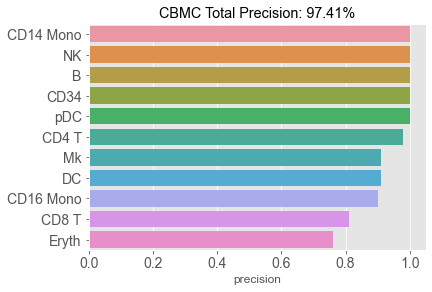

In [98]:
# plot precision for each celltype and show the total precision
dataset = 'CBMC'
fig, ax = plt.subplots()
mpl.style.use('ggplot')
order = precision_df.sort_values(by='precision',ascending=False).ref_celltype
sns.barplot(data=precision_df,y=ref_col,x='precision',order=order,orient='h',ax=ax)
# ax.set_xticklabels(labels = order,rotation=90)
ax.set(title=f'{dataset} Total Precision: {total_precision:.2%}',ylabel='')